#  Notebook Summary:

In this notebook, I performed EDA on data downloaded from pushshift API. I first processed the data to prepare it for EDA, then I divided my EDA into three main groups - 

* [**Analyze the urls**](#Analyze-URLs)
  * I looked at the urls that most commonly appeared in each subreddit
  
* [**Analyze the title characteristics**](#Analyze-Title-Characteristics) (word count and title length)
  * I looked at the distribution of word count and length of the titles for the submissions
  
* [**Analyze the words in the title**](#Analyze-Words-in-the-Title)
  * I looked at the words in the title in three different ways
  * [**Common Words**](#Common-Words) - using count vectorizer, I compared the top 25 words for each subreddit with and without stop words, and for 1-,2-,and 3-ngram word combinations.  I took the top 900 word for each subreddit, then graphed the top 25 for each one, and how it's value compared to the other subreddit.  I also normalized the appearance numbers since my data was imbalanced (democrats-123668, Republican-90351)
  * [**Unique Words**](#Unique-Words)  - I looked at the top 1000 and top 5000 words in each subreddit. For each scenario I found the words that appeared the most in one subreddit while not appearing in the other.  I eliminated stop words for this analysis, I also looked at this for 1-,2-, and 3-ngram words.
  * [**Sentiment Analysis**](#Sentiment-Analysis) - I performed sentiment analysis on each subreddit and found a lot of sarcasm just in the first few posts of both subreddits (which sentiment analysis doesn't analyze well).  Both subreddits also had similar distributions, so I performed limited sentiment analysis.
  
The results of this analyses affected how I analyzed URLs, title characteristics, and title words in the modeling phase.  I did vectorization, but I did not do sentiment analysis.  See Notebook 5 for modeling.


In [326]:
pip install seaborn==0.11.0

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# from Lab 5.02
# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400



# imports from NLP II lecture

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# Load data

df = pd.read_csv('../data/reps_and_dems.csv')

In [4]:
df.head()

,created_utc,id,num_comments,score,subreddit,title,url
0,1602943707,jcvqal,2,1,democrats,Happy Halloween!,https://i.redd.it/jo3xacq3xnt51.jpg
1,1602945905,jcwcnk,2,1,democrats,"someone I follow pointed out that Russia today is making content (in English for Americans) attacking anti racists unless the racist happens to be Jewish his comment was ""rejected"" by Russia today",https://i.redd.it/yg8h7i2j3ot51.png
2,1602945922,jcwctt,0,1,democrats,HOW DONALD TRUMP AND THE REPUBLICAN PARTY SCREWED THE AMERICAN WORKER,https://www.reddit.com/r/democrats/comments/jcwctt/how_donald_trump_and_the_republican_party_screwed/
3,1602946014,jcwdt1,0,1,democrats,BTRTN: Ten Days in November... Would You Make This Deal to Get Rid of Trump?,http://www.borntorunthenumbers.com/2020/10/btrtn-ten-days-in-november-would-you.html
4,1602946028,jcwdy3,0,1,democrats,Never forget that long after he's gone our children will have to memorize this history.,https://youtu.be/TeOePoa4z-c


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214019 entries, 0 to 214018
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   created_utc   214019 non-null  int64 
 1   id            214019 non-null  object
 2   num_comments  214019 non-null  int64 
 3   score         214019 non-null  int64 
 4   subreddit     214019 non-null  object
 5   title         214019 non-null  object
 6   url           214019 non-null  object
dtypes: int64(3), object(4)
memory usage: 11.4+ MB


---
#  Preprocess
---
## Add columns with title length and word count.  
##  Clean up the url

In [6]:
df['title_length'] = df['title'].apply(lambda x: len(x))

In [7]:
df['title_word_count'] = df['title'].apply(lambda x: len(x.split()))

In [8]:
df['url_long'] = df['url'].apply(lambda x: x.split('/'))
df['url_primary'] = df['url_long'].apply(lambda x: x[2])

In [9]:
df.head()

,created_utc,id,num_comments,score,subreddit,title,url,title_length,title_word_count,url_long,url_primary
0,1602943707,jcvqal,2,1,democrats,Happy Halloween!,https://i.redd.it/jo3xacq3xnt51.jpg,16,2,"[https:, , i.redd.it, jo3xacq3xnt51.jpg]",i.redd.it
1,1602945905,jcwcnk,2,1,democrats,"someone I follow pointed out that Russia today is making content (in English for Americans) attacking anti racists unless the racist happens to be Jewish his comment was ""rejected"" by Russia today",https://i.redd.it/yg8h7i2j3ot51.png,196,32,"[https:, , i.redd.it, yg8h7i2j3ot51.png]",i.redd.it
2,1602945922,jcwctt,0,1,democrats,HOW DONALD TRUMP AND THE REPUBLICAN PARTY SCREWED THE AMERICAN WORKER,https://www.reddit.com/r/democrats/comments/jcwctt/how_donald_trump_and_the_republican_party_screwed/,69,11,"[https:, , www.reddit.com, r, democrats, comments, jcwctt, how_donald_trump_and_the_republican_party_screwed, ]",www.reddit.com
3,1602946014,jcwdt1,0,1,democrats,BTRTN: Ten Days in November... Would You Make This Deal to Get Rid of Trump?,http://www.borntorunthenumbers.com/2020/10/btrtn-ten-days-in-november-would-you.html,76,15,"[http:, , www.borntorunthenumbers.com, 2020, 10, btrtn-ten-days-in-november-would-you.html]",www.borntorunthenumbers.com
4,1602946028,jcwdy3,0,1,democrats,Never forget that long after he's gone our children will have to memorize this history.,https://youtu.be/TeOePoa4z-c,87,15,"[https:, , youtu.be, TeOePoa4z-c]",youtu.be


---
# Analyze URLs
---

In [62]:
rep_url_vcs = df[df['subreddit'] == 'Republican']['url_primary'].value_counts()

In [63]:
rep_url_vcs[rep_url_vcs > 100]

www.reddit.com             11086
i.redd.it                   7004
www.youtube.com             4139
www.liveaction.org          3111
youtu.be                    2755
                           ...  
www.cnsnews.com              106
www.thelibertyeagle.com      103
www.bbc.com                  103
time.com                     102
www.theepochtimes.com        101
Name: url_primary, Length: 99, dtype: int64

<BarContainer object of 99 artists>

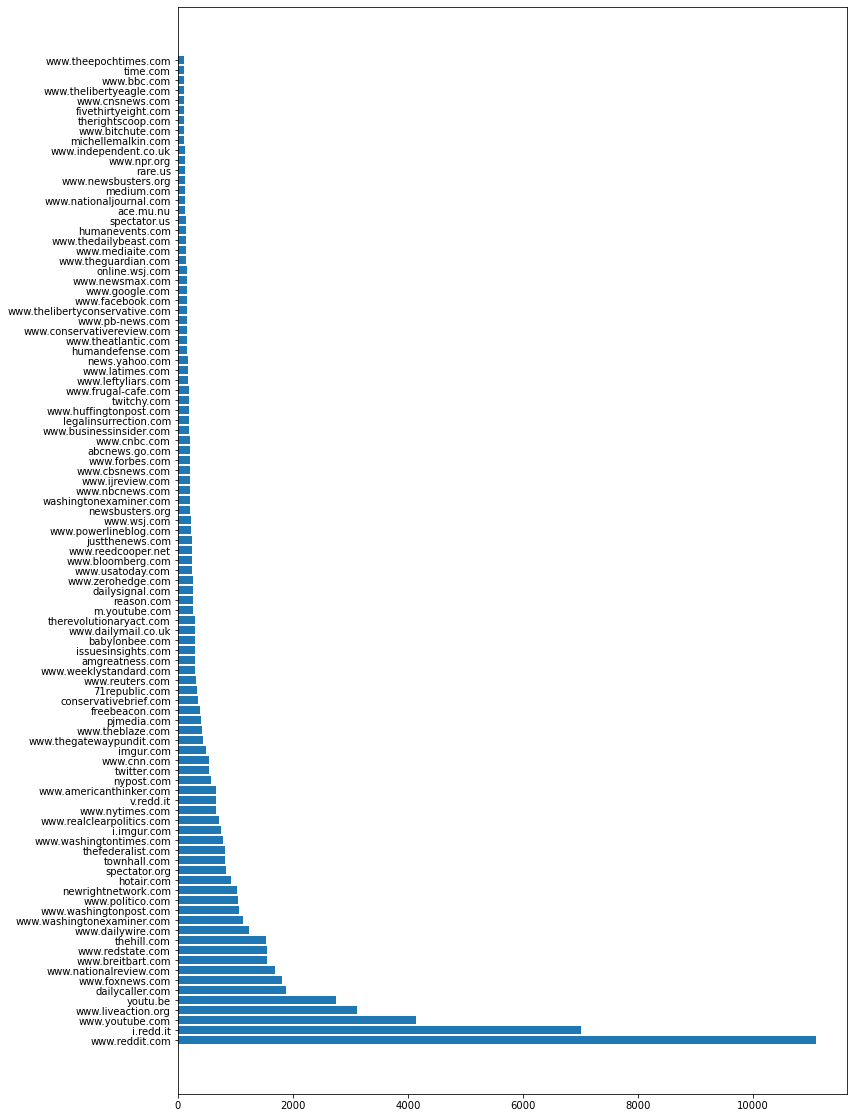

In [64]:
plt.figure(figsize = (12,20))
plt.barh(rep_url_vcs[rep_url_vcs > 100].index, rep_url_vcs[rep_url_vcs > 100])

In [65]:
dem_url_vcs = df[df['subreddit'] == 'democrats']['url_primary'].value_counts()

In [66]:
dem_url_vcs[dem_url_vcs > 100]

www.reddit.com             17964
www.washingtonpost.com      5679
twitter.com                 5424
www.youtube.com             4866
i.redd.it                   4851
                           ...  
www.nationaljournal.com      107
qz.com                       105
mobile.nytimes.com           105
www.brookings.edu            104
jimheath.tv                  104
Name: url_primary, Length: 111, dtype: int64

<BarContainer object of 111 artists>

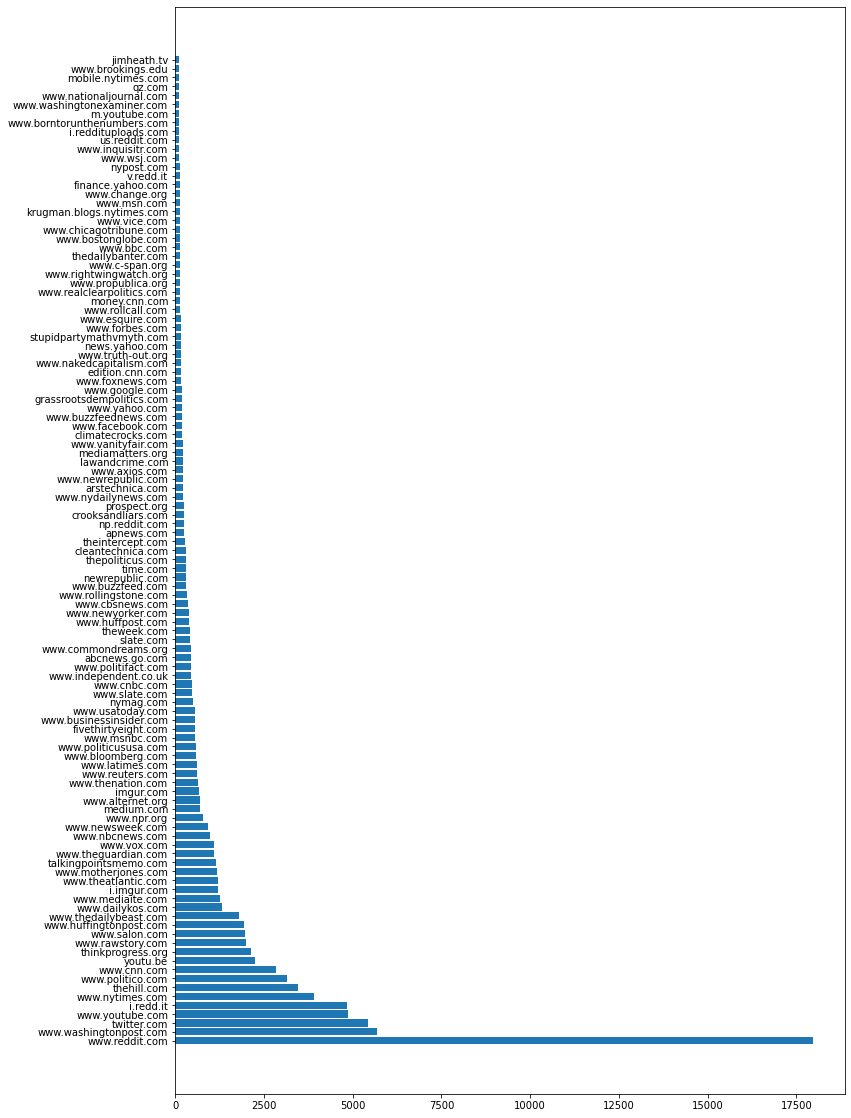

In [67]:
plt.figure(figsize = (12,20))
plt.barh(dem_url_vcs[dem_url_vcs > 100].index, dem_url_vcs[dem_url_vcs > 100])

In [68]:
dem_url_vcs.rename('dem_url_primary',inplace=True)

www.reddit.com            17964
www.washingtonpost.com     5679
twitter.com                5424
www.youtube.com            4866
i.redd.it                  4851
                          ...  
theextract.net                1
www.nbc.com                   1
ca.finance.yahoo.com          1
www.bop.gov                   1
thenycalliance.org            1
Name: dem_url_primary, Length: 6410, dtype: int64

In [69]:
rep_url_vcs.rename('rep_url_primary',inplace = True)

www.reddit.com             11086
i.redd.it                   7004
www.youtube.com             4139
www.liveaction.org          3111
youtu.be                    2755
                           ...  
erlc.com                       1
www.saf.org                    1
tullyspage.blogspot.com        1
religion.blogs.cnn.com         1
1minutepolitics.com            1
Name: rep_url_primary, Length: 5825, dtype: int64

In [70]:
all_url_prim = pd.concat([dem_url_vcs,rep_url_vcs], axis=1)

In [71]:
all_url_prim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10224 entries, www.reddit.com to 1minutepolitics.com
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   dem_url_primary  6410 non-null   float64
 1   rep_url_primary  5825 non-null   float64
dtypes: float64(2)
memory usage: 239.6+ KB


In [72]:
overlap_url_prim = all_url_prim.dropna()

In [73]:
# because the na's are created for a column that didn't have any posts for that one, replace with 0 is reasonable here

all_url_prim = all_url_prim.fillna(0)

In [74]:
all_url_prim.head(5)

,dem_url_primary,rep_url_primary
www.reddit.com,17964.0,11086.0
www.washingtonpost.com,5679.0,1056.0
twitter.com,5424.0,550.0
www.youtube.com,4866.0,4139.0
i.redd.it,4851.0,7004.0


In [75]:
all_url_prim['rep_url_primary']

www.reddit.com             11086.0
www.washingtonpost.com      1056.0
twitter.com                  550.0
www.youtube.com             4139.0
i.redd.it                   7004.0
                            ...   
erlc.com                       1.0
www.saf.org                    1.0
tullyspage.blogspot.com        1.0
religion.blogs.cnn.com         1.0
1minutepolitics.com            1.0
Name: rep_url_primary, Length: 10224, dtype: float64

In [76]:
all_url_prim

,dem_url_primary,rep_url_primary
www.reddit.com,17964.0,11086.0
www.washingtonpost.com,5679.0,1056.0
twitter.com,5424.0,550.0
www.youtube.com,4866.0,4139.0
i.redd.it,4851.0,7004.0
...,...,...
erlc.com,0.0,1.0
www.saf.org,0.0,1.0
tullyspage.blogspot.com,0.0,1.0
religion.blogs.cnn.com,0.0,1.0


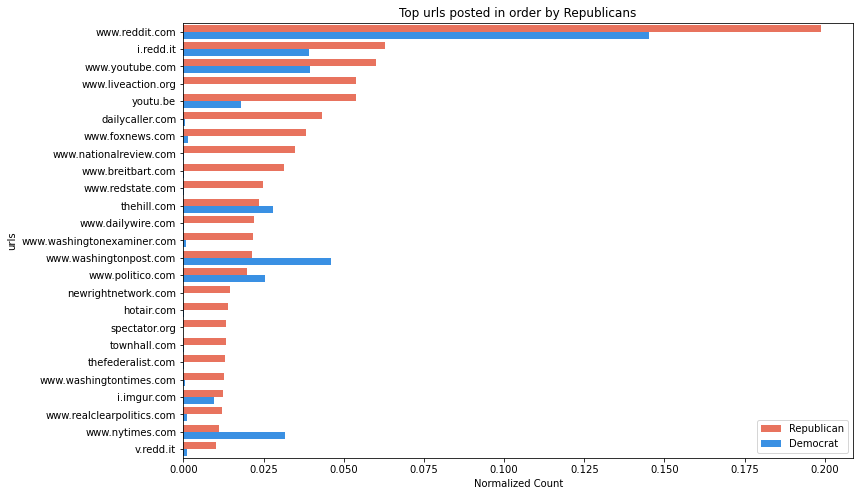

In [77]:
df1 = pd.DataFrame(dem_url_vcs).reset_index().rename(columns = {'index':'urls','dem_url_primary':'count'})
df1['norm_count'] = df1['count']/len(df[df['subreddit'] == 'democrats'])
df1['category'] = 'Democrat'

df2 = pd.DataFrame(rep_url_vcs).reset_index().rename(columns = {'index':'urls','rep_url_primary':'count'})
df2['norm_count'] = df1['count']/len(df[df['subreddit'] == 'Republican'])
df2['category'] = 'Republican'


df_combo = pd.merge(df2,df1, on='urls', how = 'outer').head(25)
r = df_combo[['urls','norm_count_x','category_x']].rename(columns = {'norm_count_x':'Normalized Count','category_x':'category'})
d = df_combo[['urls','norm_count_y','category_y']].rename(columns = {'norm_count_y':'Normalized Count','category_y':'category'})
df_combined = pd.concat([r,d])
df_combined.head()
    
plt.figure(figsize = (12,8))
sns.barplot(y='urls', x='Normalized Count', hue='category', palette={'Republican':'tomato','Democrat':'dodgerblue'}, data=df_combined)

plt.title('Top urls posted in order by Republicans')
plt.legend();


In [78]:
df_combined.head(5)

,urls,Normalized Count,category
0,www.reddit.com,0.198825,Republican
1,i.redd.it,0.062855,Republican
2,www.youtube.com,0.060033,Republican
3,www.liveaction.org,0.053857,Republican
4,youtu.be,0.053691,Republican


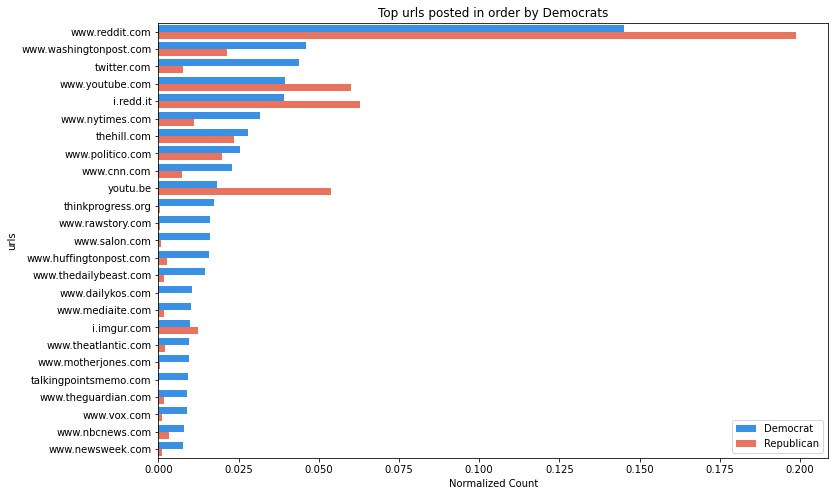

In [79]:
df1 = pd.DataFrame(dem_url_vcs).reset_index().rename(columns = {'index':'urls','dem_url_primary':'count'})
df1['norm_count'] = df1['count']/len(df[df['subreddit'] == 'democrats'])
df1['category'] = 'Democrat'

df2 = pd.DataFrame(rep_url_vcs).reset_index().rename(columns = {'index':'urls','rep_url_primary':'count'})
df2['norm_count'] = df1['count']/len(df[df['subreddit'] == 'Republican'])
df2['category'] = 'Republican'


df_combo = pd.merge(df1,df2, on='urls', how = 'outer').head(25)
r = df_combo[['urls','norm_count_x','category_x']].rename(columns = {'norm_count_x':'Normalized Count','category_x':'category'})
d = df_combo[['urls','norm_count_y','category_y']].rename(columns = {'norm_count_y':'Normalized Count','category_y':'category'})
df_combined = pd.concat([r,d])
df_combined.head()



#Plot the data
plt.figure(figsize = (12,8))
sns.barplot(y='urls', x='Normalized Count', hue='category', palette={'Republican':'tomato','Democrat':'dodgerblue'}, data=df_combined)

plt.title('Top urls posted in order by Democrats')
plt.legend();

In [80]:
df_combined.head()

,urls,Normalized Count,category
0,www.reddit.com,0.145260,Democrat
1,www.washingtonpost.com,0.045921,Democrat
2,twitter.com,0.043859,Democrat
3,www.youtube.com,0.039347,Democrat
4,i.redd.it,0.039226,Democrat


### was having issues comparing to NYT: so first going to clean up the URL's in the reddit to delete the www - before counting (there are some duplicates


In [84]:
#from NLP_tweets local
df['url_primary_long'] = df['url_primary'].replace('www.', '', regex=True)

In [85]:
df['url_primary_long'].head()

0                  i.redd.it
1                  i.redd.it
2                 reddit.com
3    borntorunthenumbers.com
4                   youtu.be
Name: url_primary_long, dtype: object

In [86]:
df[df['subreddit'] == 'democrats']['url_primary'].value_counts()

www.reddit.com            17964
www.washingtonpost.com     5679
twitter.com                5424
www.youtube.com            4866
i.redd.it                  4851
                          ...  
theextract.net                1
www.nbc.com                   1
ca.finance.yahoo.com          1
www.bop.gov                   1
thenycalliance.org            1
Name: url_primary, Length: 6410, dtype: int64

In [87]:
df[df['subreddit'] == 'Republican']['url_primary'].value_counts()

www.reddit.com             11086
i.redd.it                   7004
www.youtube.com             4139
www.liveaction.org          3111
youtu.be                    2755
                           ...  
erlc.com                       1
www.saf.org                    1
tullyspage.blogspot.com        1
religion.blogs.cnn.com         1
1minutepolitics.com            1
Name: url_primary, Length: 5825, dtype: int64

In [88]:
dems_urls_long = df[df['subreddit'] == 'democrats']['url_primary_long'].value_counts()
dems_urls_long

reddit.com              17970
washingtonpost.com       5683
twitter.com              5453
youtube.com              4890
i.redd.it                4851
                        ...  
verifiedpolitics.com        1
infoworld.com               1
toofab.com                  1
blog.actblue.com            1
thenycalliance.org          1
Name: url_primary_long, Length: 6217, dtype: int64

In [89]:
reps_urls_long =df[df['subreddit'] == 'Republican']['url_primary_long'].value_counts()
reps_urls_long

reddit.com                           11092
i.redd.it                             7004
youtube.com                           4179
liveaction.org                        3111
youtu.be                              2755
                                     ...  
fosters.com                              1
thelibertarianideal.wordpress.com        1
wmnf.org                                 1
flatlandkc.org                           1
1minutepolitics.com                      1
Name: url_primary_long, Length: 5615, dtype: int64

In [90]:
# how many urls have greater than two splits so 1520/6217
dems_urls_long.reset_index()['index'][dems_urls_long.reset_index()['index'].apply(lambda x: len(x.split('.'))).sort_values() > 2]

4                                  i.redd.it
17                               i.imgur.com
42                         independent.co.uk
45                            abcnews.go.com
57                             np.reddit.com
                        ...                 
6195                  events.vademocrats.org
6196                  donate.barackobama.com
6209    whitepeoplemourningromney.tumblr.com
6211                          foia.state.gov
6215                        blog.actblue.com
Name: index, Length: 1520, dtype: object

In [91]:
# shos that 1288 out of 5615 still have three words
reps_urls_long.reset_index()['index'][reps_urls_long.reset_index()['index'].apply(lambda x: len(x.split('.'))).sort_values() > 2]

1                               i.redd.it
21                            i.imgur.com
25                              v.redd.it
43                        dailymail.co.uk
45                          m.youtube.com
                      ...                
5594          coronanews123.wordpress.com
5598                housegop.leadpages.co
5603                   tomshardware.co.uk
5604              intelligence.senate.gov
5611    thelibertarianideal.wordpress.com
Name: index, Length: 1288, dtype: object

In [92]:
all_url_prim_long = pd.concat([dems_urls_long,reps_urls_long], axis=1, keys = ['Dems','Reps'])

In [93]:
all_url_prim_long.head()

,Dems,Reps
reddit.com,17970.0,11092.0
washingtonpost.com,5683.0,1058.0
twitter.com,5453.0,553.0
youtube.com,4890.0,4179.0
i.redd.it,4851.0,7004.0


In [94]:
all_url_prim_long.shape

(9841, 2)

In [95]:
list(all_url_prim_long.index.unique())

['reddit.com',
 'washingtonpost.com',
 'twitter.com',
 'youtube.com',
 'i.redd.it',
 'nytimes.com',
 'thehill.com',
 'politico.com',
 'cnn.com',
 'youtu.be',
 'thinkprogress.org',
 'rawstory.com',
 'salon.com',
 'huffingtonpost.com',
 'thedailybeast.com',
 'dailykos.com',
 'mediaite.com',
 'i.imgur.com',
 'theatlantic.com',
 'motherjones.com',
 'talkingpointsmemo.com',
 'theguardian.com',
 'vox.com',
 'nbcnews.com',
 'newsweek.com',
 'slate.com',
 'npr.org',
 'medium.com',
 'alternet.org',
 'imgur.com',
 'thenation.com',
 'reuters.com',
 'latimes.com',
 'bloomberg.com',
 'politicususa.com',
 'msnbc.com',
 'fivethirtyeight.com',
 'businessinsider.com',
 'usatoday.com',
 'newrepublic.com',
 'nymag.com',
 'cnbc.com',
 'independent.co.uk',
 'politifact.com',
 'commondreams.org',
 'abcnews.go.com',
 'theweek.com',
 'huffpost.com',
 'newyorker.com',
 'cbsnews.com',
 'rollingstone.com',
 'apnews.com',
 'buzzfeed.com',
 'mediamatters.org',
 'time.com',
 'thepoliticus.com',
 'cleantechnica.com'

### after removing duplicates, redraw graphs of most appear websites just in case

In [96]:
pd.DataFrame(reps_urls_long).reset_index().rename(columns = {'index':'urls','url_primary_long':'count'})

,urls,count
0,reddit.com,11092
1,i.redd.it,7004
2,youtube.com,4179
3,liveaction.org,3111
4,youtu.be,2755
...,...,...
5610,fosters.com,1
5611,thelibertarianideal.wordpress.com,1
5612,wmnf.org,1
5613,flatlandkc.org,1


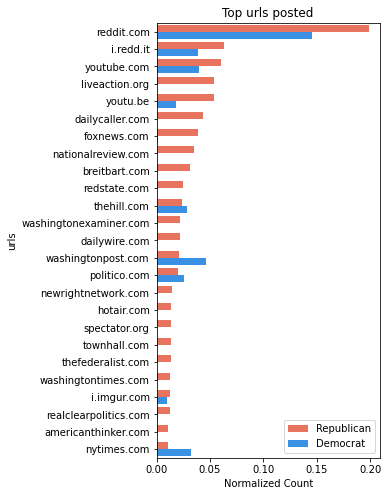

In [111]:
total_num_dem_posts = len(df[df['subreddit'] == 'democrats'])
df1 = pd.DataFrame(dems_urls_long).reset_index().rename(columns = {'index':'urls','url_primary_long':'count'})
df1['norm_count'] = df1['count']/total_num_dem_posts
df1['category'] = 'Democrat'

total_num_rep_posts = len(df[df['subreddit'] == 'Republican'])
df2 = pd.DataFrame(reps_urls_long).reset_index().rename(columns = {'index':'urls','url_primary_long':'count'})
df2['norm_count'] = df1['count']/total_num_rep_posts 
df2['category'] = 'Republican'


df_combo = pd.merge(df2,df1, on='urls', how = 'outer').head(25)
r = df_combo[['urls','norm_count_x','category_x']].rename(columns = {'norm_count_x':'Normalized Count','category_x':'category'})
d = df_combo[['urls','norm_count_y','category_y']].rename(columns = {'norm_count_y':'Normalized Count','category_y':'category'})
df_combined = pd.concat([r,d])
df_combined.head()
    
plt.figure(figsize = (4,8))
sns.barplot(y='urls', x='Normalized Count', hue='category', palette={'Republican':'tomato','Democrat':'dodgerblue'}, data=df_combined)

plt.title('Top urls posted')
plt.legend();


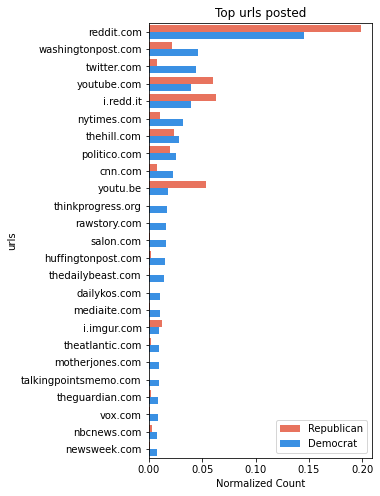

In [112]:
total_num_dem_posts = len(df[df['subreddit'] == 'democrats'])
df1 = pd.DataFrame(dems_urls_long).reset_index().rename(columns = {'index':'urls','url_primary_long':'count'})
df1['norm_count'] = df1['count']/total_num_dem_posts
df1['category'] = 'Democrat'

total_num_rep_posts = len(df[df['subreddit'] == 'Republican'])
df2 = pd.DataFrame(reps_urls_long).reset_index().rename(columns = {'index':'urls','url_primary_long':'count'})
df2['norm_count'] = df1['count']/total_num_rep_posts 
df2['category'] = 'Republican'


df_combo = pd.merge(df1,df2, on='urls', how = 'outer').head(25)
d = df_combo[['urls','norm_count_x','category_x']].rename(columns = {'norm_count_x':'Normalized Count','category_x':'category'})
r = df_combo[['urls','norm_count_y','category_y']].rename(columns = {'norm_count_y':'Normalized Count','category_y':'category'})
df_combined = pd.concat([r,d])
df_combined.head()



#Plot the data
plt.figure(figsize = (4,8))
sns.barplot(y='urls', x='Normalized Count', hue='category', palette={'Republican':'tomato','Democrat':'dodgerblue'}, data=df_combined)

plt.title('Top urls posted')
plt.legend();

---
# Analyze Title Characteristics
---

In [10]:
df.head()

,created_utc,id,num_comments,score,subreddit,title,url,title_length,title_word_count,url_long,url_primary
0,1602943707,jcvqal,2,1,democrats,Happy Halloween!,https://i.redd.it/jo3xacq3xnt51.jpg,16,2,"[https:, , i.redd.it, jo3xacq3xnt51.jpg]",i.redd.it
1,1602945905,jcwcnk,2,1,democrats,"someone I follow pointed out that Russia today is making content (in English for Americans) attacking anti racists unless the racist happens to be Jewish his comment was ""rejected"" by Russia today",https://i.redd.it/yg8h7i2j3ot51.png,196,32,"[https:, , i.redd.it, yg8h7i2j3ot51.png]",i.redd.it
2,1602945922,jcwctt,0,1,democrats,HOW DONALD TRUMP AND THE REPUBLICAN PARTY SCREWED THE AMERICAN WORKER,https://www.reddit.com/r/democrats/comments/jcwctt/how_donald_trump_and_the_republican_party_screwed/,69,11,"[https:, , www.reddit.com, r, democrats, comments, jcwctt, how_donald_trump_and_the_republican_party_screwed, ]",www.reddit.com
3,1602946014,jcwdt1,0,1,democrats,BTRTN: Ten Days in November... Would You Make This Deal to Get Rid of Trump?,http://www.borntorunthenumbers.com/2020/10/btrtn-ten-days-in-november-would-you.html,76,15,"[http:, , www.borntorunthenumbers.com, 2020, 10, btrtn-ten-days-in-november-would-you.html]",www.borntorunthenumbers.com
4,1602946028,jcwdy3,0,1,democrats,Never forget that long after he's gone our children will have to memorize this history.,https://youtu.be/TeOePoa4z-c,87,15,"[https:, , youtu.be, TeOePoa4z-c]",youtu.be


In [11]:
df2 = df[['subreddit','title','title_length','title_word_count']]

In [12]:
df2['subreddit'].value_counts()

democrats     123668
Republican     90351
Name: subreddit, dtype: int64

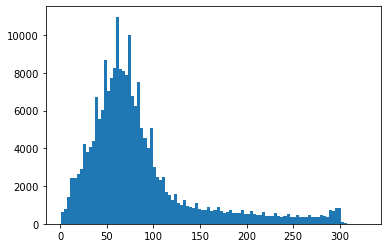

In [13]:
# from lab 5.02 

plt.hist(df2['title_length'], bins = 100);

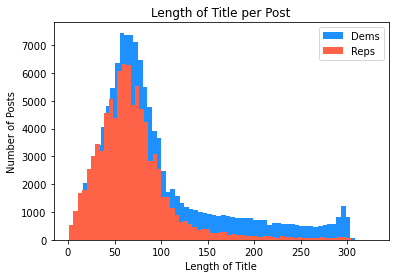

In [14]:
# reference https://matplotlib.org/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py 
# for multiple subplots

fig, ax = plt.subplots()

ax.hist(df[df['subreddit'] == 'democrats']['title_length'], bins = 66, color = 'dodgerblue', label = 'Dems');
ax.hist(df[df['subreddit'] == 'Republican']['title_length'], bins = 66, color = 'tomato', label = 'Reps');

ax.legend()
ax.set_title('Length of Title per Post')
ax.set_xlabel('Length of Title')
ax.set_ylabel('Number of Posts')

plt.show();

In [15]:
df_title_len = df[['title_length','subreddit']]
df_title_len

,title_length,subreddit
0,16,democrats
1,196,democrats
2,69,democrats
3,76,democrats
4,87,democrats
...,...,...
214014,46,Republican
214015,113,Republican
214016,112,Republican
214017,30,Republican


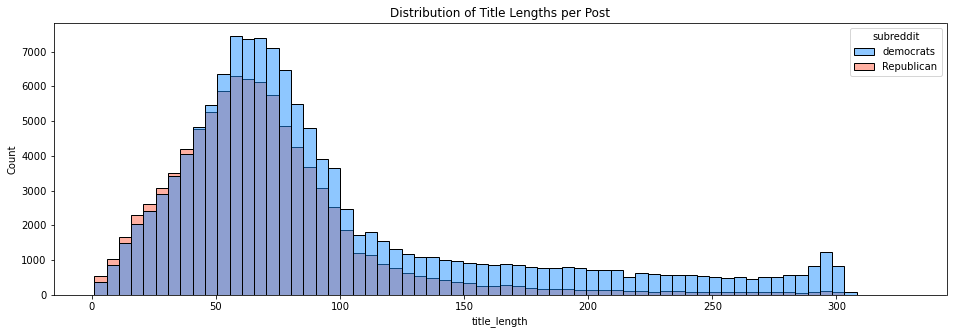

In [16]:
#https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot

plt.figure(figsize = (16,5))
sns.histplot(data=df_title_len, x="title_length", hue="subreddit", bins = 66, palette={'democrats':'dodgerblue','Republican':'tomato',}, multiple="layer")
plt.title('Distribution of Title Lengths per Post');

In [17]:
df_title_len[df_title_len['subreddit'] == 'democrats'].describe()

,title_length
count,123668.00000
mean,95.64978
std,67.42555
min,1.00000
25%,53.00000
50%,74.00000
75%,112.00000
max,328.00000


In [18]:
df_title_len[df_title_len['subreddit'] == 'Republican'].describe()

,title_length
count,90351.000000
mean,69.996004
std,42.373175
min,1.000000
25%,44.000000
50%,64.000000
75%,85.000000
max,313.000000


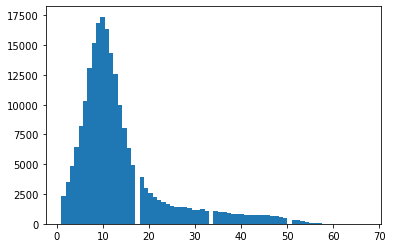

In [19]:
plt.hist(df2['title_word_count'], bins = 70);

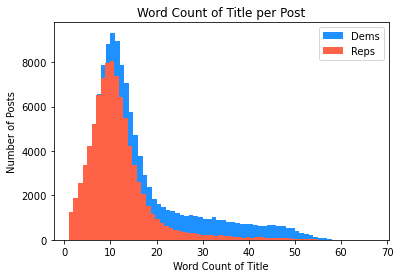

In [20]:
# reference https://matplotlib.org/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py 
# for multiple subplots

fig, ax = plt.subplots()

ax.hist(df[df['subreddit'] == 'democrats']['title_word_count'], bins = 66, color = 'dodgerblue', label = 'Dems');
ax.hist(df[df['subreddit'] == 'Republican']['title_word_count'], bins = 61, color = 'tomato', label = 'Reps');

ax.legend()
ax.set_title('Word Count of Title per Post')
ax.set_xlabel('Word Count of Title')
ax.set_ylabel('Number of Posts')

plt.show();

In [21]:
df_word_count = df[['title_word_count','subreddit']]
df_word_count

,title_word_count,subreddit
0,2,democrats
1,32,democrats
2,11,democrats
3,15,democrats
4,15,democrats
...,...,...
214014,9,Republican
214015,18,Republican
214016,18,Republican
214017,7,Republican


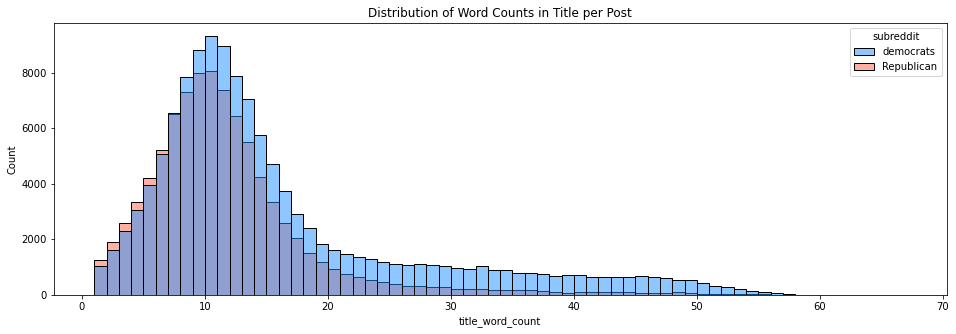

In [22]:
#https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot

plt.figure(figsize = (16,5))
sns.histplot(data=df_word_count, x="title_word_count", hue="subreddit", bins = 66, palette={'democrats':'dodgerblue','Republican':'tomato',}, multiple="layer")
plt.title('Distribution of Word Counts in Title per Post');

In [23]:
df_word_count[df_word_count['subreddit'] == 'democrats'].describe()

,title_word_count
count,123668.000000
mean,15.585228
std,11.210358
min,1.000000
25%,8.000000
50%,12.000000
75%,18.000000
max,67.000000


In [24]:
df_word_count[df_word_count['subreddit'] == 'Republican'].describe()

,title_word_count
count,90351.000000
mean,11.328519
std,7.083637
min,1.000000
25%,7.000000
50%,10.000000
75%,14.000000
max,61.000000


---
# Analyze Words in the Title
---
## Common Words
 * **Review top 25 words for each subreddit (with and without stop words)**

### Republicans 

In [25]:
df2 = df[['subreddit','title','title_length','title_word_count']].copy()
df2['subreddit'] = df2['subreddit'].map({'Republican':1,'democrats':0}).copy()
df2.head()

,subreddit,title,title_length,title_word_count
0,0,Happy Halloween!,16,2
1,0,"someone I follow pointed out that Russia today is making content (in English for Americans) attacking anti racists unless the racist happens to be Jewish his comment was ""rejected"" by Russia today",196,32
2,0,HOW DONALD TRUMP AND THE REPUBLICAN PARTY SCREWED THE AMERICAN WORKER,69,11
3,0,BTRTN: Ten Days in November... Would You Make This Deal to Get Rid of Trump?,76,15
4,0,Never forget that long after he's gone our children will have to memorize this history.,87,15


In [25]:
#dataset for republicans

reps_df = df2[df2['subreddit'] == 1]
reps_df.head()

,subreddit,title,title_length,title_word_count
123668,1,"Biden says he will raise taxes immediately, even if the economy is struggling",77,13
123669,1,"Duplicate Ballots Applications Flood Pennsylvania – 334,000 Duplicates Already Rejected",87,10
123670,1,"The Associated Press finally talks about the Hunter Biden emails, but...",72,11
123671,1,"Kristen Welker, upcoming presidential debate moderator, has deep Democrat ties",78,10
123672,1,understandable have a nice day,30,5


In [26]:
#try removing stop words
reps_title = reps_df['title']

cvec3 = CountVectorizer(max_features=1_000, stop_words = 'english')
cvec3.fit(reps_title)

reps_title_t = cvec3.transform(reps_title)

reps_title_df = pd.DataFrame(reps_title_t.todense(),
                         columns=cvec3.get_feature_names())

#top appearing words
reps_title_df.sum().sort_values(ascending = False).head(25);

In [27]:
#try with stop words
reps_title = reps_df['title']

cvec4 = CountVectorizer(max_features=1_000)
cvec4.fit(reps_title)

reps_title_t4 = cvec4.transform(reps_title)

reps_title_df4 = pd.DataFrame(reps_title_t4.todense(),
                         columns=cvec4.get_feature_names())

#top appearing words
reps_title_df4.sum().sort_values(ascending = False).head(25);

In [28]:
#try removing stop words and 2 grams
reps_title = reps_df['title']

cvec11 = CountVectorizer(max_features=1_000, stop_words = 'english', ngram_range=(2,2))
cvec11.fit(reps_title)

reps_title_t11 = cvec11.transform(reps_title)

reps_title_df11 = pd.DataFrame(reps_title_t11.todense(),
                         columns=cvec11.get_feature_names())

#top appearing words
reps_title_df11.sum().sort_values(ascending = False).head(25);

In [29]:
#try with stop words and 2 grams
reps_title = reps_df['title']

cvec12 = CountVectorizer(max_features=1_000, ngram_range=(2,2))
cvec12.fit(reps_title)

reps_title_t12 = cvec12.transform(reps_title)

reps_title_df12 = pd.DataFrame(reps_title_t12.todense(),
                         columns=cvec12.get_feature_names())

#top appearing words
reps_title_df12.sum().sort_values(ascending = False).head(25);

In [30]:
#try removing stop words and 3 grams
reps_title = reps_df['title']

cvec13 = CountVectorizer(max_features=1_000, stop_words = 'english', ngram_range=(3,3))
cvec13.fit(reps_title)

reps_title_t13 = cvec13.transform(reps_title)

reps_title_df13 = pd.DataFrame(reps_title_t13.todense(),
                         columns=cvec13.get_feature_names())

#top appearing words
reps_title_df13.sum().sort_values(ascending = False).head(25);

In [31]:
#try with stop words and 3 grams
reps_title = reps_df['title']

cvec14 = CountVectorizer(max_features=1_000, ngram_range=(3,3))
cvec14.fit(reps_title)

reps_title_t14 = cvec14.transform(reps_title)

reps_title_df14 = pd.DataFrame(reps_title_t14.todense(),
                         columns=cvec14.get_feature_names())

#top appearing words
reps_title_df14.sum().sort_values(ascending = False).head(25);

### Democrats

In [32]:
dems_df = df2[df2['subreddit'] == 0]
dems_df.head()

,subreddit,title,title_length,title_word_count
0,0,Happy Halloween!,16,2
1,0,"someone I follow pointed out that Russia today is making content (in English for Americans) attacking anti racists unless the racist happens to be Jewish his comment was ""rejected"" by Russia today",196,32
2,0,HOW DONALD TRUMP AND THE REPUBLICAN PARTY SCREWED THE AMERICAN WORKER,69,11
3,0,BTRTN: Ten Days in November... Would You Make This Deal to Get Rid of Trump?,76,15
4,0,Never forget that long after he's gone our children will have to memorize this history.,87,15


In [33]:
#try removing stop words
dems_title = dems_df['title']

cvec5 = CountVectorizer(max_features=1_000, stop_words = 'english')
cvec5.fit(dems_title)

dems_title_t = cvec5.transform(dems_title)

dems_title_df = pd.DataFrame(dems_title_t.todense(),
                         columns=cvec5.get_feature_names())

#top appearing words
dems_title_df.sum().sort_values(ascending = False).head(25);

In [34]:
#try with stop words
dems_title = dems_df['title']

cvec6 = CountVectorizer(max_features=1_000)
cvec6.fit(dems_title)

dems_title_t2 = cvec6.transform(dems_title)

dems_title_df2 = pd.DataFrame(dems_title_t2.todense(),
                         columns=cvec6.get_feature_names())

#top appearing words
dems_title_df2.sum().sort_values(ascending = False).head(25);

In [35]:
#try removing stop words with n_grams = 2
dems_title = dems_df['title']

cvec7 = CountVectorizer(max_features=1_000, stop_words = 'english', ngram_range=(2,2))
cvec7.fit(dems_title)

dems_title_t7 = cvec7.transform(dems_title)

dems_title_df7 = pd.DataFrame(dems_title_t7.todense(),
                         columns=cvec7.get_feature_names())

#top appearing words
dems_title_df7.sum().sort_values(ascending = False).head(25);

In [36]:
#try with stop words with n_grams = 2
dems_title = dems_df['title']

cvec8 = CountVectorizer(max_features=1_000, ngram_range=(2,2))
cvec8.fit(dems_title)

dems_title_t8 = cvec8.transform(dems_title)

dems_title_df8 = pd.DataFrame(dems_title_t8.todense(),
                         columns=cvec8.get_feature_names())

#top appearing words
dems_title_df8.sum().sort_values(ascending = False).head(25);

In [37]:
#try removing stop words with n_grams = 3
dems_title = dems_df['title']

cvec9 = CountVectorizer(max_features=1_000, stop_words = 'english', ngram_range=(3,3))
cvec9.fit(dems_title)

dems_title_t9 = cvec9.transform(dems_title)

dems_title_df9 = pd.DataFrame(dems_title_t9.todense(),
                         columns=cvec9.get_feature_names())

#top appearing words
dems_title_df9.sum().sort_values(ascending = False).head(25);

In [38]:
#try with stop words with n_grams = 3
dems_title = dems_df['title']

cvec10 = CountVectorizer(max_features=1_000, ngram_range=(3,3))
cvec10.fit(dems_title)

dems_title_t10 = cvec10.transform(dems_title)

dems_title_df10 = pd.DataFrame(dems_title_t10.todense(),
                         columns=cvec10.get_feature_names())

#top appearing words
dems_title_df10.sum().sort_values(ascending = False).head(25);

### Comparison graphs

In [530]:
reps_df;

In [531]:
dems_df;

In [532]:
reps_title_df14;

In [40]:
#df_reps and df_dems should be in the form of df's with just words (e.g. reps_title_df14)
#title is the plot title

def bar_chart_compare_byR(df_reps, df_dems,plot_title):
    df1 = df_reps.sum().sort_values(ascending = False).head(900)
    df1 = df1.reset_index().rename(columns = {'index':'words',0:'count'})
    df1['norm_count'] = df1['count']/len(df_reps)
    df1['category'] = 'Republican'

    df2 = df_dems.sum().sort_values(ascending = False).head(900)
    df2 = df2.reset_index().rename(columns = {'index':'words',0:'count'})
    df2['norm_count'] = df2['count']/len(df_dems)
    df2['category'] = 'Democrat'


    df = pd.merge(df1,df2, on='words', how = 'outer').head(25)
    r = df[['words','norm_count_x','category_x']].rename(columns = {'norm_count_x':'Normalized Count','category_x':'category'})
    d = df[['words','norm_count_y','category_y']].rename(columns = {'norm_count_y':'Normalized Count','category_y':'category'})
    df_combined = pd.concat([r,d])
    df_combined.head()

    plt.figure(figsize = (10,8))
    #I read the documentation to learn palettes can take in dictionaries (super helpful when certain categories are associated with a given color)
    sns.barplot(y='words', x='Normalized Count', hue='category',palette={'Republican':'tomato','Democrat':'dodgerblue'}, data=df_combined)

    plt.title(plot_title)
    plt.legend();
    
def bar_chart_compare_byD(df_reps, df_dems,plot_title):
    df1 = df_reps.sum().sort_values(ascending = False).head(900)
    df1 = df1.reset_index().rename(columns = {'index':'words',0:'count'})
    df1['norm_count'] = df1['count']/len(df_reps)
    df1['category'] = 'Republican'

    df2 = df_dems.sum().sort_values(ascending = False).head(900)
    df2 = df2.reset_index().rename(columns = {'index':'words',0:'count'})
    df2['norm_count'] = df2['count']/len(df_dems)
    df2['category'] = 'Democrat'

    df = pd.merge(df2,df1, on='words', how = 'outer').head(25)
    d = df[['words','norm_count_x','category_x']].rename(columns = {'norm_count_x':'Normalized Count','category_x':'category'})
    r = df[['words','norm_count_y','category_y']].rename(columns = {'norm_count_y':'Normalized Count','category_y':'category'})
    df_combined = pd.concat([r,d])
    df_combined.head()
    
    plt.figure(figsize = (10,8))
    sns.barplot(y='words', x='Normalized Count', hue='category', palette={'Republican':'tomato','Democrat':'dodgerblue'}, data=df_combined)

    plt.title(plot_title)
    plt.legend();

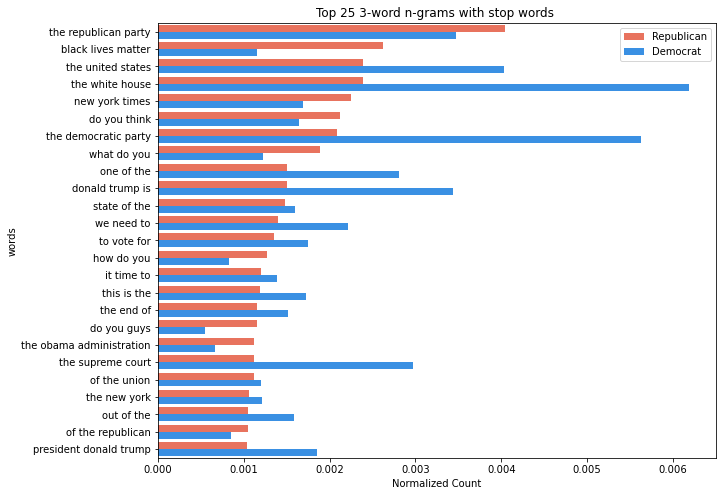

In [43]:
bar_chart_compare_byR(reps_title_df14, dems_title_df10, "Top 25 3-word n-grams with stop words ")

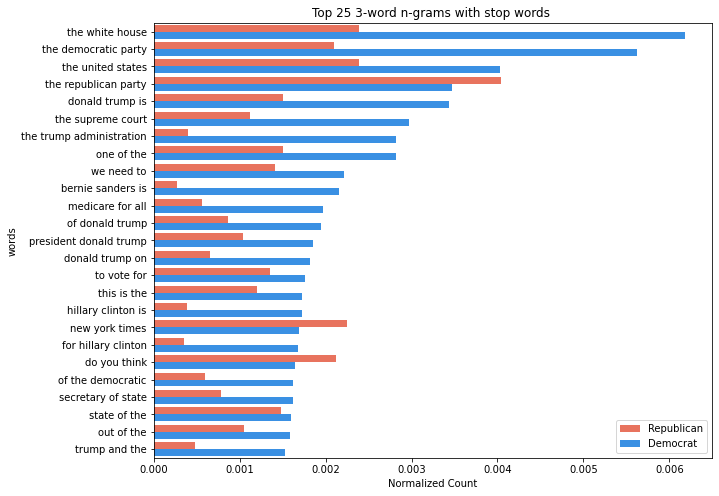

In [44]:
bar_chart_compare_byD(reps_title_df14, dems_title_df10, "Top 25 3-word n-grams with stop words ")

3 word ngrams without stop words

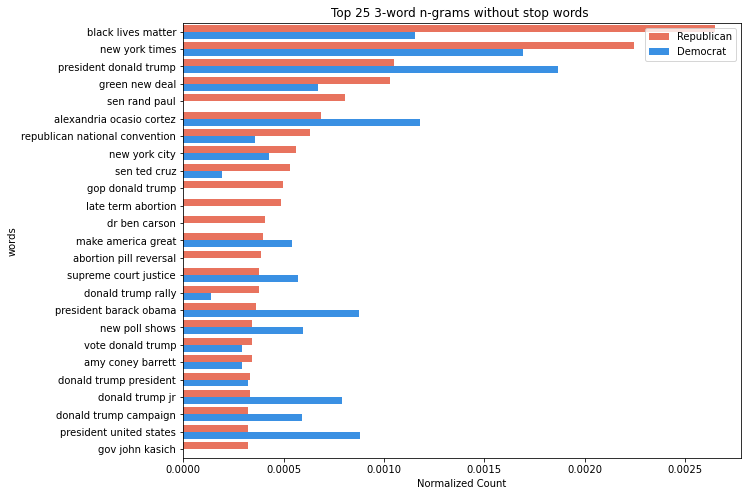

In [50]:
bar_chart_compare_byR(reps_title_df13, dems_title_df9, "Top 25 3-word n-grams without stop words ")

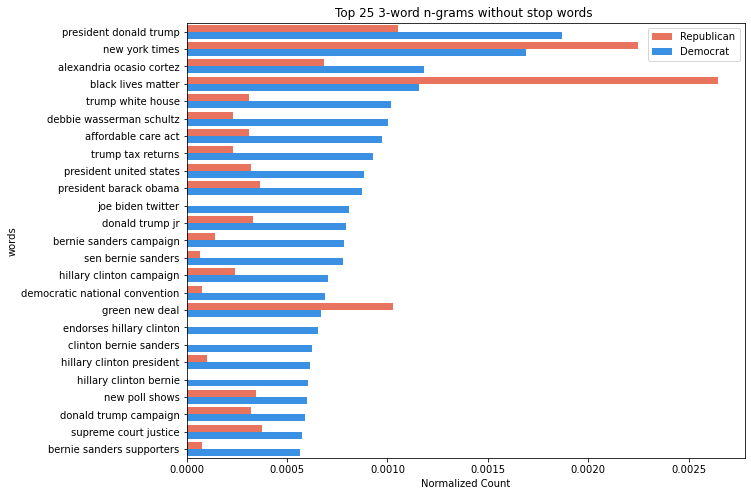

In [49]:
bar_chart_compare_byD(reps_title_df13, dems_title_df9, "Top 25 3-word n-grams without stop words ")

**Note: I'm pulling the 900 most common three-word phrases from each subreddit, then comparing them. So if a word doesn't appear on a given chart, it means that this word wasn't in the top 900 on a given list.**

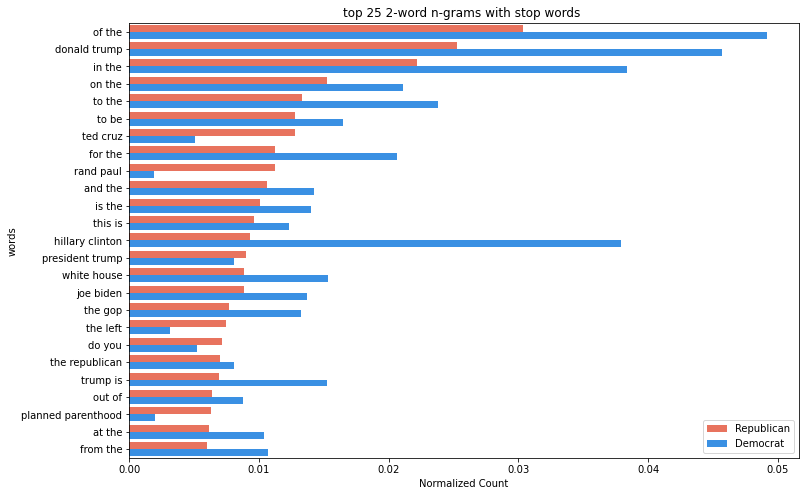

In [46]:
bar_chart_compare_byR(reps_title_df12, dems_title_df8, "top 25 2-word n-grams with stop words ")

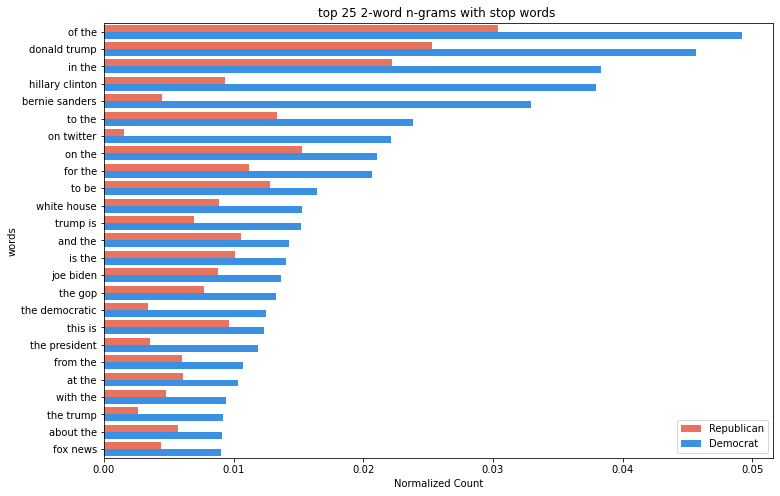

In [47]:
bar_chart_compare_byD(reps_title_df12, dems_title_df8, "top 25 2-word n-grams with stop words ")

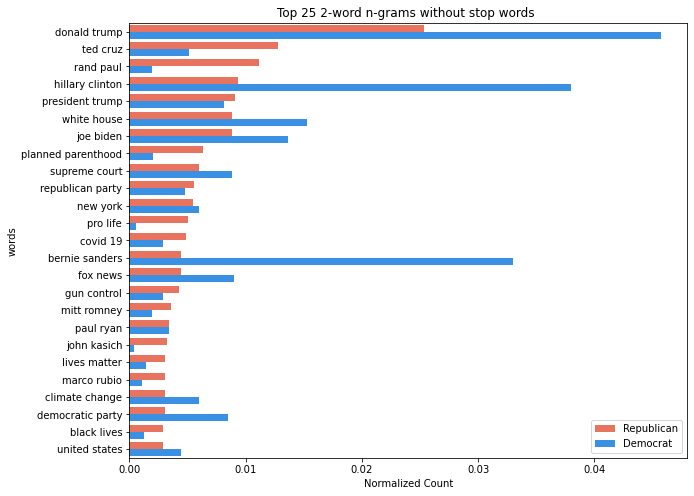

In [45]:
bar_chart_compare_byR(reps_title_df11, dems_title_df7, "Top 25 2-word n-grams without stop words ")

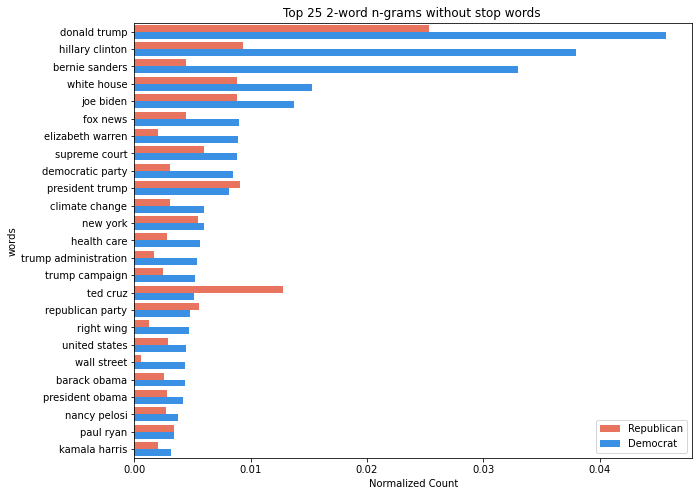

In [46]:
bar_chart_compare_byD(reps_title_df11, dems_title_df7, "Top 25 2-word n-grams without stop words ")

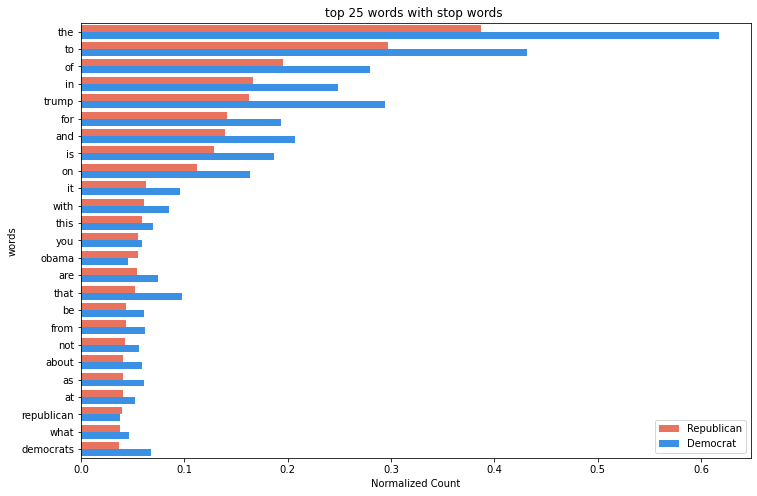

In [242]:
bar_chart_compare_byR(reps_title_df4, dems_title_df2, "top 25 words with stop words ")

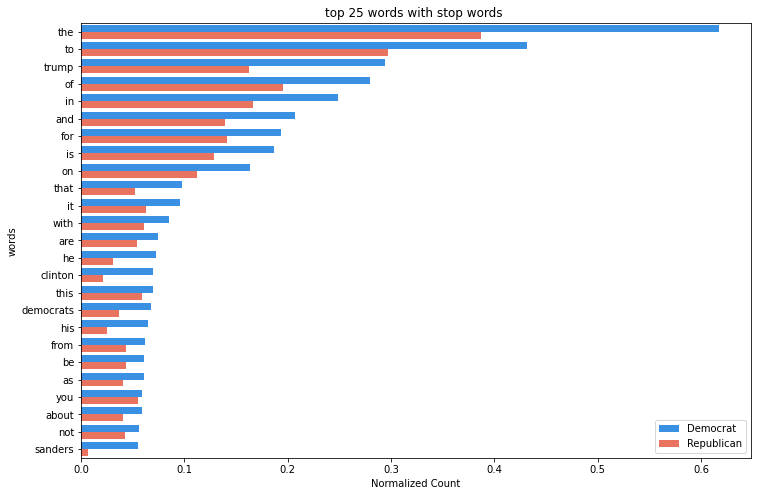

In [243]:
bar_chart_compare_byD(reps_title_df4, dems_title_df2, "top 25 words with stop words ")

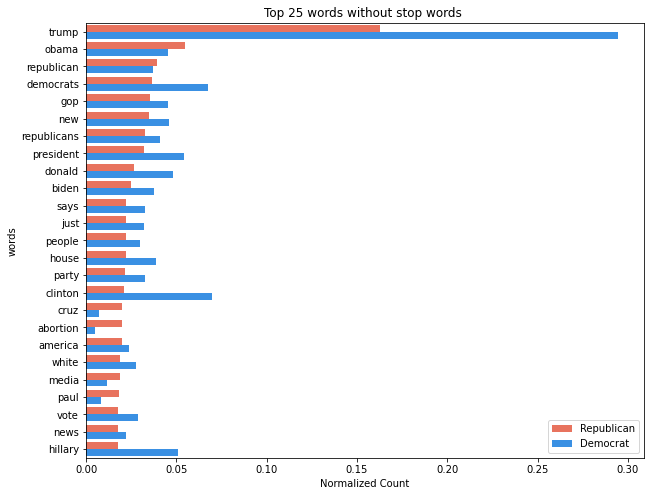

In [47]:
bar_chart_compare_byR(reps_title_df, dems_title_df, "Top 25 words without stop words ")

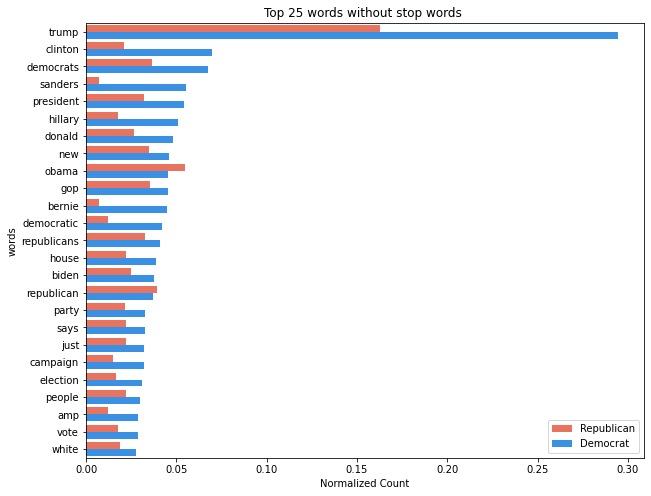

In [48]:
bar_chart_compare_byD(reps_title_df, dems_title_df, "Top 25 words without stop words ")

## Unique Words
 * **Look at words that appear in only one of the two subreddits)**

In [51]:
def missing_compare(df_reps, df_dems,plot_title):
    #process dataframe so that has normalized counts of how many times a word appears
    df1 = df_reps.sum().sort_values(ascending = False)
    df1 = df1.reset_index().rename(columns = {'index':'words',0:'count'})
    df1['norm_count'] = df1['count']/len(df_reps)
    df1['category'] = 'Republican'

    df2 = df_dems.sum().sort_values(ascending = False)
    df2 = df2.reset_index().rename(columns = {'index':'words',0:'count'})
    df2['norm_count'] = df2['count']/len(df_dems)
    df2['category'] = 'Democrat'

    # merge the two dataframes, then clean them
    df = pd.merge(df1,df2, on='words', how = 'outer')
    df['category_x'] = 'Republican'
    df['category_y'] = 'Democrat'
    df = df.fillna(0)
    
    df_x = df[df['norm_count_x'] == 0]
    df_y = df[df['norm_count_y'] == 0]
    
    
    #reformat dataframe for input into seaborn
    r = df_y[['words','norm_count_x','category_x']].rename(columns = {'norm_count_x':'Normalized Count','category_x':'category'}).head(25)
    d = df_x[['words','norm_count_y','category_y']].rename(columns = {'norm_count_y':'Normalized Count','category_y':'category'}).head(25)
    df_combined = pd.concat([r,d])
    
    

    #https://seaborn.pydata.org/examples/faceted_histogram.html
    
    plt.figure(figsize = (12,8));
     
    sns.catplot(x='Normalized Count', y='words', 
            row = 'category', hue='category',
            palette={'Republican':'tomato','Democrat':'dodgerblue'},
            orient="h", kind ='bar',
            data=d);
    
    plt.title(plot_title);
    plt.legend();
    
    sns.catplot(x='Normalized Count', y='words', 
            row = 'category', hue='category',
            palette={'Republican':'tomato','Democrat':'dodgerblue'},
            orient="h", kind ='bar',
            data=r);

    plt.title(plot_title);
    plt.legend();
    
    return

In [52]:
# Function to create a count vectorized df with a given number of features, with/without stop words, and n-gram range choice

# series_title - should be a series of title names
# num_features - number of features for CountVectorizer
# stop_words_choice - 'english' or 'none'
# ng_range - ngram_range



def CountVec(series_title, num_features,stop_words_choice,ng_range):
    cvec = CountVectorizer(max_features=num_features, stop_words = stop_words_choice, ngram_range=ng_range)
    cvec.fit(series_title)

    series_title_T = cvec.transform(series_title)

    title_df = pd.DataFrame(series_title_T.todense(),
                         columns=cvec.get_feature_names())

    #top appearing words
    # title_df.sum().sort_values(ascending = False).head(25);
    return title_df

In [56]:
# create function to graph top 25 words that are unique to each subreddit after searching top X words
reps_title = reps_df['title']
dems_title = dems_df['title']

# num_features - number of features for CountVectorizer
# stop_words_choice - 'english' or 'none'
# ng_range - ngram_range


def graph_25_unique(num_features,ng_range, stop_words_choice = None, rep_df = reps_title,dem_df = dems_title ):
    r_5k_eng_2 = CountVec(rep_df, num_features,stop_words_choice,ng_range)
    d_5k_eng_2 = CountVec(dem_df, num_features,stop_words_choice,ng_range)
    
    if stop_words_choice == 'english':
        stop = 'without stop words, '
    else:
        stop = ''
    
    title = f'Top 25 unique words to a subreddit, {stop}of top {num_features} words per each, ngram is {ng_range}.'

    missing_compare(r_5k_eng_2, d_5k_eng_2,title);
    return

<Figure size 864x576 with 0 Axes>

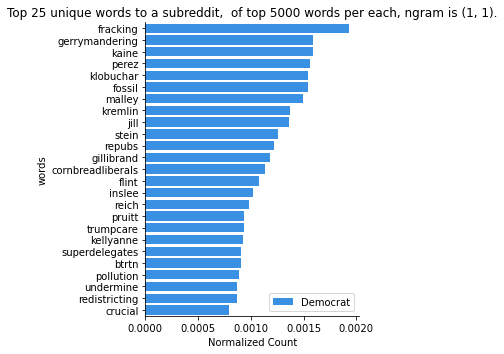

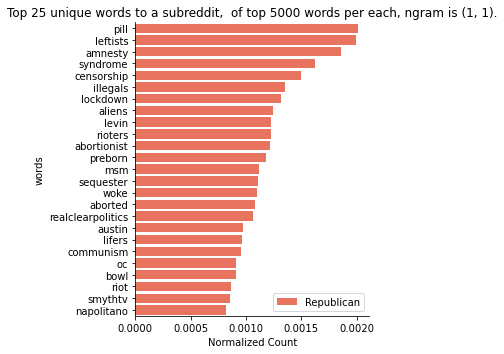

In [54]:
graph_25_unique(5000,(1,1))

<Figure size 864x576 with 0 Axes>

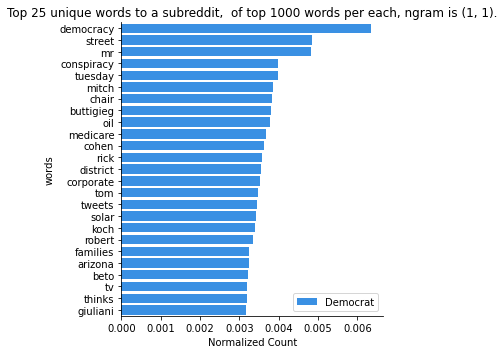

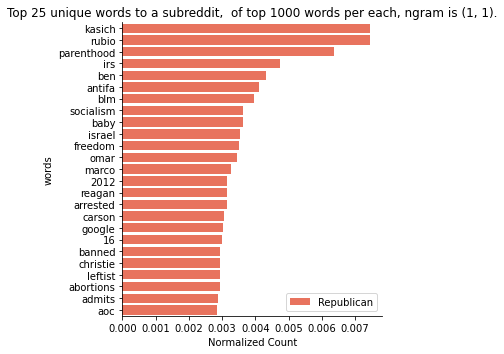

In [55]:
graph_25_unique(1000,(1,1))

<Figure size 864x576 with 0 Axes>

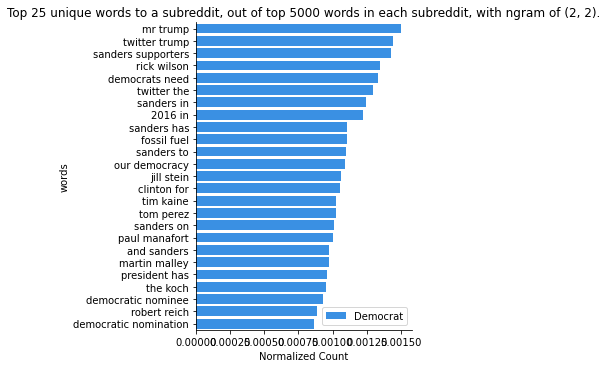

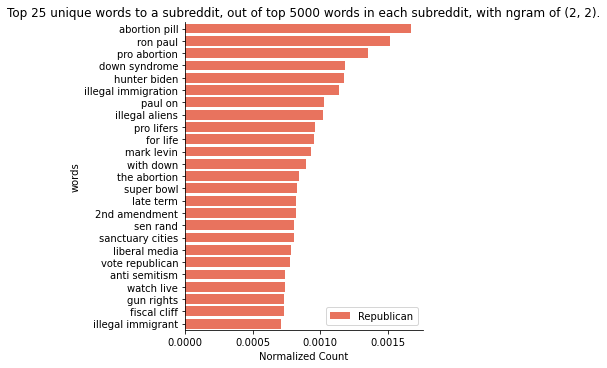

In [526]:
graph_25_unique(5000,(2,2))

<Figure size 864x576 with 0 Axes>

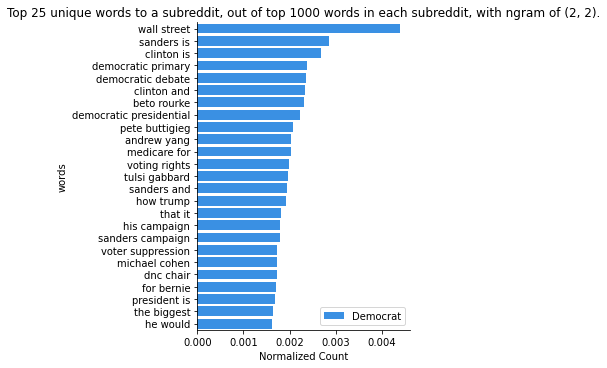

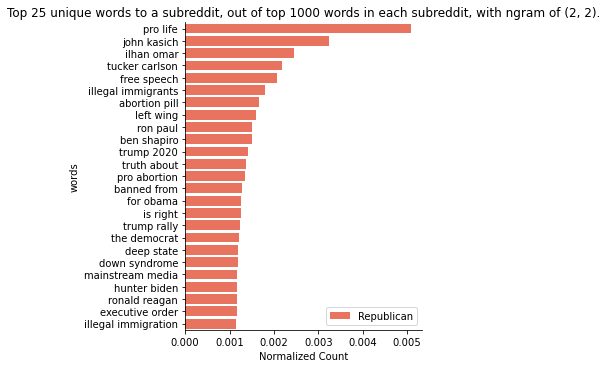

In [527]:
graph_25_unique(1000,(2,2))

<Figure size 864x576 with 0 Axes>

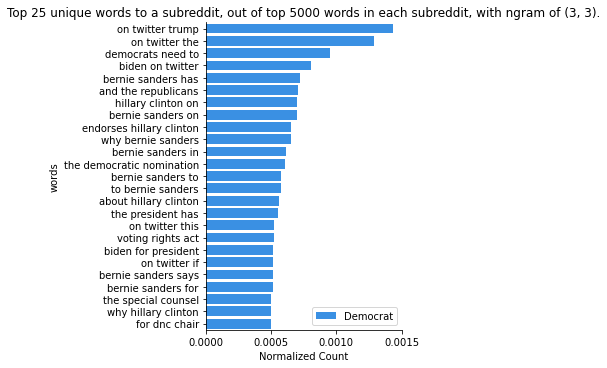

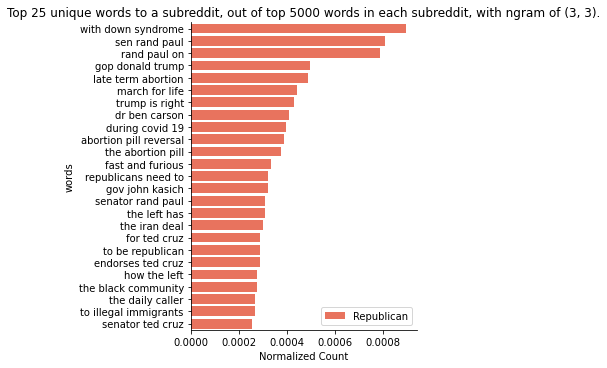

In [528]:
graph_25_unique(5000,(3,3))

<Figure size 864x576 with 0 Axes>

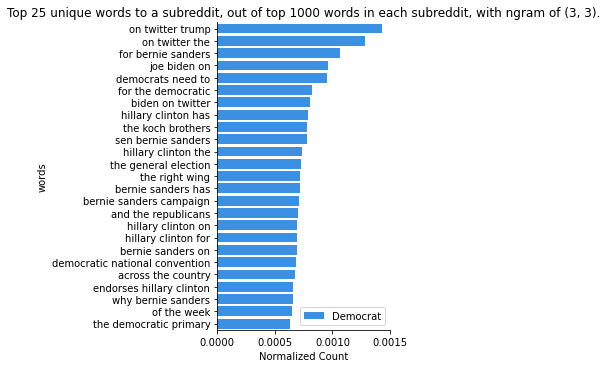

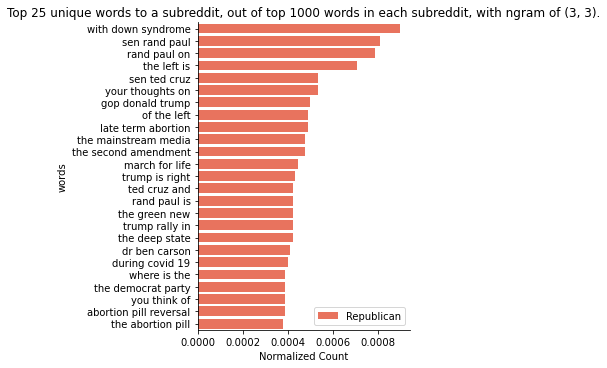

In [529]:
graph_25_unique(1000,(3,3))

## Sentiment Analysis
 * **Look at sentiment of the title**

In [266]:
# Based on Modeling_with_VADER local class

dems_corpus = list(dems_df['title'])
reps_corpus = list(reps_df['title'])

In [277]:
# instantiate SIA

sia = SentimentIntensityAnalyzer()

In [280]:
# create a dataframe that contains text and the polarity scores for each title

dicts_dems = []

for title in dems_corpus:
    scores = sia.polarity_scores(title)
    scores['title'] = title
    dicts_dems.append(scores)
    
df_dems_scores = pd.DataFrame(dicts_dems)
df_reps_scores['category'] = 'Democrat'
df_dems_scores.head()

,neg,neu,pos,compound,title
0,0.000,0.200,0.800,0.6114,Happy Halloween!
1,0.322,0.678,0.000,-0.9153,"someone I follow pointed out that Russia today is making content (in English for Americans) attacking anti racists unless the racist happens to be Jewish his comment was ""rejected"" by Russia today"
2,0.215,0.604,0.181,-0.1280,HOW DONALD TRUMP AND THE REPUBLICAN PARTY SCREWED THE AMERICAN WORKER
3,0.000,1.000,0.000,0.0000,BTRTN: Ten Days in November... Would You Make This Deal to Get Rid of Trump?
4,0.000,0.894,0.106,0.1695,Never forget that long after he's gone our children will have to memorize this history.


In [287]:
df_dems_scores.sort_values(by = 'compound', ascending = False).head()

,neg,neu,pos,compound,title
70690,0.049,0.492,0.458,0.9838,"Max Boot on Twitter: ""Of course @POTUS won't meet with this Russian freedom fighter, but @SenJohnMcCain does."" -- John McCain on Twitter: ""Great to see Vladimir Kara-Murza today - he's a true hero, survivor &amp; patriot who courageously continues to fight for freedom in #Russia"""
50207,0.041,0.430,0.529,0.9803,All of Bernie's endorsed candidates WIN. All of Alexandria Ocasio-Cortezs endorsed candidates WIN. All (but one) of Our Revolutions six endorsed candidate WIN. All three Justice Democrats endorsed candidates WIN. Main Stream Media... loses.
72368,0.000,0.641,0.359,0.9766,Hey just wanted to share a thought with the opposing party. Why dont we all get along very well? Im right winged but i love you guys and love that we have mixed culture. I wish we could all enjoy some chinesse together and get to know eachother. Just dropping in to say hey
6307,0.000,0.588,0.412,0.9766,"Joe Manchin: Wearing a mask in one of the best tools we have, especially when paired with social distancing and hand washing, to prevent the spread of #COVID19. Join me in celebrating #WorldMaskWeek by wearing your mask. It’s safe, effective, and protects you and your loved ones. #MaskUpWV"
19108,0.000,0.622,0.378,0.9742,Does the USA need a third party? Not just a third party but perhaps also a way to make third parties more viable like proportional representation in whole or part like say Germany ? Would people be happier would there be more harmony is each sub group has specific representation ?


In [288]:
df_dems_scores.sort_values(by = 'neg', ascending = False).head()

,neg,neu,pos,compound,title
6826,1.0,0.0,0.0,-0.3612,Clueless
7594,1.0,0.0,0.0,-0.7579,STUPID FUCKS
42884,1.0,0.0,0.0,-0.6249,Racism
42889,1.0,0.0,0.0,-0.6249,Racism
44109,1.0,0.0,0.0,-0.1779,Seriously.


In [289]:
df_dems_scores.sort_values(by = 'pos', ascending = False).head()

,neg,neu,pos,compound,title
386,0.0,0.0,1.0,0.4574,Yes!
64729,0.0,0.0,1.0,0.2960,Yep
57684,0.0,0.0,1.0,0.4215,True
57956,0.0,0.0,1.0,0.4939,Enjoy.
58185,0.0,0.0,1.0,0.3400,Ha


In [293]:
df_dems_scores.describe()

,neg,neu,pos,compound
count,123668.000000,123668.000000,123668.000000,123668.000000
mean,0.103896,0.805569,0.090261,-0.035294
std,0.144354,0.178837,0.135302,0.415851
min,0.000000,0.000000,0.000000,-0.994500
25%,0.000000,0.690000,0.000000,-0.340000
50%,0.000000,0.814000,0.000000,0.000000
75%,0.190000,1.000000,0.162000,0.250000
max,1.000000,1.000000,1.000000,0.983800


In [281]:
dicts_reps = []

for title in reps_corpus:
    scores = sia.polarity_scores(title)
    scores['title'] = title
    dicts_reps.append(scores)
    
df_reps_scores = pd.DataFrame(dicts_reps)
df_reps_scores['category'] = 'Republican'
df_reps_scores.head()

,neg,neu,pos,compound,title,category
0,0.189,0.811,0.000,-0.4215,"Biden says he will raise taxes immediately, even if the economy is struggling",Republican
1,0.292,0.708,0.000,-0.5106,"Duplicate Ballots Applications Flood Pennsylvania – 334,000 Duplicates Already Rejected",Republican
2,0.000,1.000,0.000,0.0000,"The Associated Press finally talks about the Hunter Biden emails, but...",Republican
3,0.000,1.000,0.000,0.0000,"Kristen Welker, upcoming presidential debate moderator, has deep Democrat ties",Republican
4,0.000,0.517,0.483,0.4215,understandable have a nice day,Republican


In [283]:
df_reps_scores.sort_values(by = 'compound', ascending = False).head()

,neg,neu,pos,compound,title,category
40257,0.00,0.288,0.712,0.9829,Merry Christmas my friends! I hope 2018 was good for you and I wish great success for you in 2019! Enjoy the Holiday!,Republican
48633,0.00,0.498,0.502,0.9756,"Best way to start 2018 is by gloating over all the winning of 2017! Check out this hilarious new video ""The Great Winning of Trump!"" Make America Great Again!",Republican
6329,0.00,0.428,0.572,0.9751,"In honor of the weekend I'd like to reward you with a giggle. Really. Watch it all. It's MAGNIFICENT. Remember to laugh, guys...always remember to laugh.",Republican
47552,0.00,0.271,0.729,0.9716,Terry McAuliffe: 'Who better to take on Trump than me?' .... ha ha ha ha ha ha ha ha ha ha,Republican
14534,0.07,0.545,0.386,0.9716,"Hey guys, Dem here, but I come in peace. I know that a lot of you guys are really smart, but I feel like this is why a lot of liberals think all Trump Supporters are stupid. I’d love to hear your thoughts? Jordan Klepper vs. Trump Supporters.",Republican


In [284]:
df_reps_scores.sort_values(by = 'neg', ascending = False).head()

,neg,neu,pos,compound,title,category
89643,1.0,0.0,0.0,-0.5423,Cheater,Republican
13583,1.0,0.0,0.0,-0.5267,Frustrated,Republican
56679,1.0,0.0,0.0,-0.7096,Sore Losers,Republican
35396,1.0,0.0,0.0,-0.1779,Dilemma,Republican
79688,1.0,0.0,0.0,-0.3400,Shameless,Republican


In [285]:
df_reps_scores.sort_values(by = 'pos', ascending = False).head()

,neg,neu,pos,compound,title,category
935,0.0,0.0,1.0,0.6486,well well well 😌,Republican
8757,0.0,0.0,1.0,0.4215,lol,Republican
37222,0.0,0.0,1.0,0.5994,Lmao,Republican
2804,0.0,0.0,1.0,0.7125,Tolerance FTW,Republican
10236,0.0,0.0,1.0,0.4939,Enjoy,Republican


In [292]:
df_reps_scores.describe()

,neg,neu,pos,compound
count,90351.000000,90351.000000,90351.000000,90351.00000
mean,0.113415,0.793581,0.092497,-0.04582
std,0.162532,0.200599,0.152980,0.39194
min,0.000000,0.000000,0.000000,-0.98880
25%,0.000000,0.659000,0.000000,-0.34000
50%,0.000000,0.804000,0.000000,0.00000
75%,0.216000,1.000000,0.170000,0.12800
max,1.000000,1.000000,1.000000,0.98290


In [294]:
df_dems_scores.describe()

,neg,neu,pos,compound
count,123668.000000,123668.000000,123668.000000,123668.000000
mean,0.103896,0.805569,0.090261,-0.035294
std,0.144354,0.178837,0.135302,0.415851
min,0.000000,0.000000,0.000000,-0.994500
25%,0.000000,0.690000,0.000000,-0.340000
50%,0.000000,0.814000,0.000000,0.000000
75%,0.190000,1.000000,0.162000,0.250000
max,1.000000,1.000000,1.000000,0.983800


**In looking at the statuses - there's a lot of sarcasm, which the sentiment analyzer is not great at detecting, so I'm not going to focus on this more**